# Advanced Machine Learning
# Final Project - Part \#1 - Anchor Paper Mission

<br>

By   
Millis Sahar, ID 123123123  
Segall Tomer, ID 123123123  

<br><br><br>

**Instructions**

The submission should include both the “Final Project Report”, as well as a working code (the anchor paper and the innovative part) with instructions how to reconstruct the reported results. 

As for the data to reconstruct the results – No need to include it in the submission. If it is not a commonly used data (e.g. mnist) please provide a link and/or instructions how to get the data.

The “Final Project Report” should be based on your previous report submissions (possibly enhanced), with a new chapter dedicated to the innovative part, and a summary.

<u>The main points that you need to address in the report are:</u>

1. Introduction 
  1. Project statement
    1. Clearly state the problem/issue/challenge that your final project address
        - You may mention the anchor paper’s objective, if it helps to better define your project statement
    2. Data sources - what are the data set(s) that you will use
    3. Evaluation - how are you going to evaluate performance

2. Related work
  1. Mention the relevant studies that you found that address a similar objective to your project statement 
    1. Shortly write about each of those papers (not more than one paragraph for each)
    2. State at least two relevant studies
  2. Please note that failing to mention a highly relevant study is an issue 

3. Anchor paper
  1. Anchor paper implementation:
    1. State the anchor paper.
    2. Reference external code repositories that you have used so for (if any).
    3. Summarize your coding effort - what was done, whether you faced technical challenges and why, gaps you still have.
    4. Provide a link to your code repository (e.g., a Git repo) where you implemented the anchor paper algorithm.
  2. Anchor paper results
    1. Report the results you obtained out of your implementation and show a comparison to the reported results in the anchor paper
    2. (optional) Report any additional results you obtained based on another data set or another configuration you have tried

4. Innovative part
  1. Restate the problem/issue/challenge
  2. Explain why it is innovative 
    1. Relate to the anchor paper and the related work that you found and explain how they are different than your work
  3. Explain your solution
  4. Implementation
    1. Reference external code repositories that you have used so for (if any).
    2. Summarize your coding effort - what was done, whether you faced 3. technical challenges and why, gaps you still have.
    3. Provide a link to your code repository (e.g., a Git repo) 
  5. Results
    1. Report the results you obtained out of your implementation 
    2. Show a comparison to other methods (e.g., the anchor paper method, methods from related work)

5. Summary
  1. Summarize this effort
    1. What was achieved
    2. How is it in comparison to the anchor paper and/or other related work
    3. (scientific) Insights gained 
  2. Open questions and future direction for further research

### Article's Code
You can find it in <a href='https://github.com/wuningxi/tBERT'>this</a> Github.


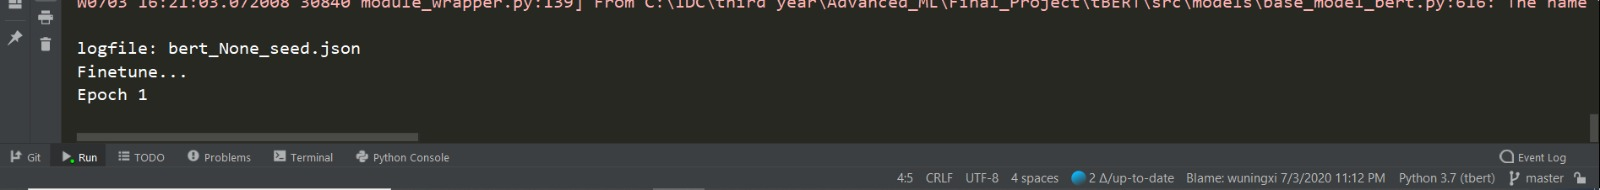

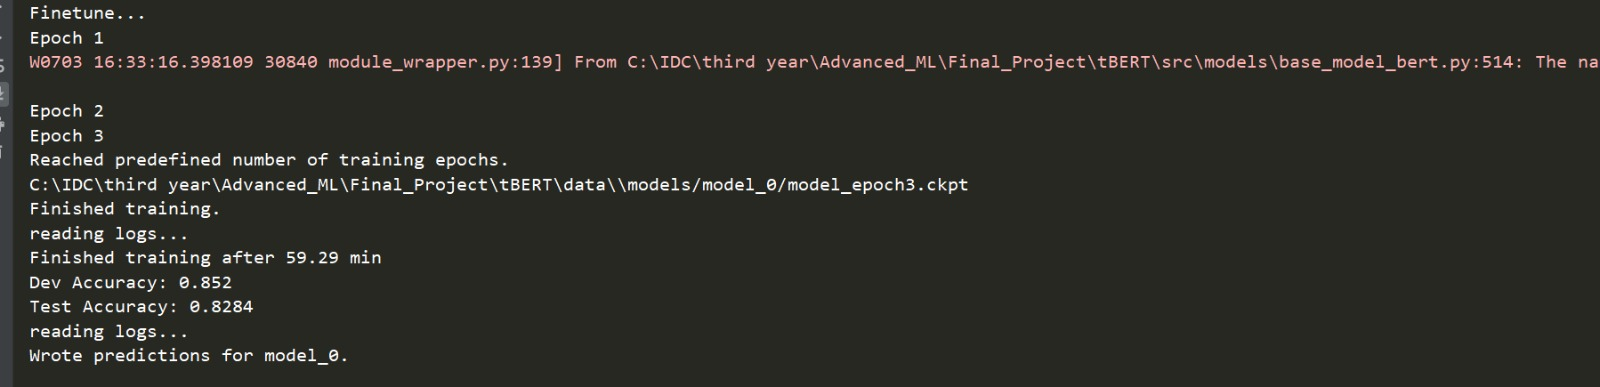

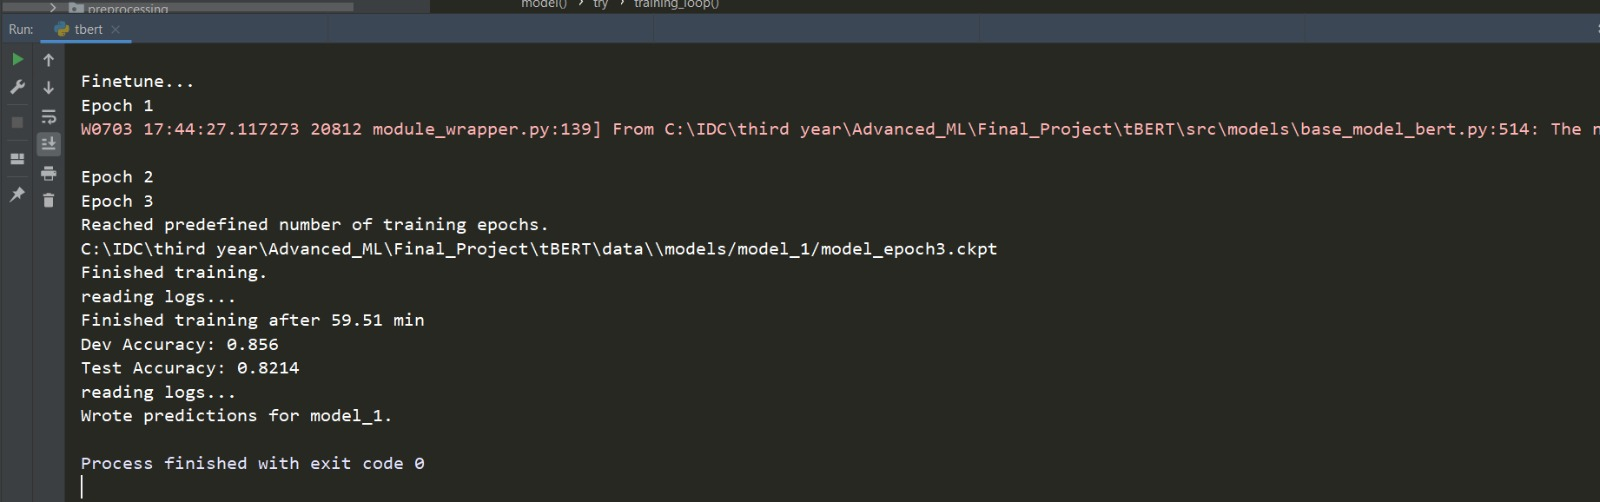

As you can see, although it's a hellish code, **we managed to run it**.  

But needed to make a better code version, while using pandas-numpy-torch platforms.

<br><br><br><br>




### Prerequisites:

In [ ]:
!pip install --quiet transformers
!pip install --quiet nlpaug

### Imports:

In [ ]:
import gc
import random
import os.path
import warnings


import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize


import torch
from torch import nn
import torch.optim as optim
from torch.cuda import empty_cache
from torch.utils.data import DataLoader, random_split


from transformers import logging
from transformers import EarlyStoppingCallback
from transformers import TrainingArguments, Trainer
from transformers import BertModel,BertTokenizer


from nlpaug.augmenter import word as naw
from nlpaug.augmenter import sentence as nas


from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score,classification_report

from google.colab import drive

##### Warnings & Verbose

In [ ]:
warnings.filterwarnings("ignore") # general
logging.set_verbosity_error() # huggingface

##### Setup -  Natural Language Tool Kit 

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

##### Setup - Google Drive

In [ ]:
drive.mount('/content/drive')
current_dir = 'drive/My Drive/Colab Notebooks/AdvancedML/Final_Project/' 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset

##### Torch's Dataset

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        x = self.encodings[idx]
        y = self.labels[idx]
        return x,y

    def __len__(self):
        return len(self.encodings)


class PairDataset(torch.utils.data.Dataset):
    def __init__(self, text1,text2,labels):
        self.text1  = text1
        self.text2  = text2
        self.labels = labels

    def __getitem__(self, idx):
        x1 = self.text1[idx]
        x2 = self.text2[idx]
        y = self.labels[idx]
        return x1,x2,y

    def __len__(self):
        return len(self.labels)

### MSRP


In [ ]:
msrp_train = current_dir + 'data/MSRP/msr-para-train.tsv'
msrp_val   = current_dir + 'data/MSRP/msr-para-val.tsv'
msrp_test  = current_dir + 'data/MSRP/msr-para-test.tsv'

##### Create a dataframe

In [ ]:
df_msrp_train = pd.read_csv(msrp_train, sep='\t', header=0, error_bad_lines=False, warn_bad_lines=False, names=['label','q1_id','q2_id','q1','q2'],usecols=[0,3,4]).dropna()
df_msrp_val   = pd.read_csv(msrp_val,   sep='\t', header=0, error_bad_lines=False, warn_bad_lines=False, names=['label','q1_id','q2_id','q1','q2'],usecols=[0,3,4]).dropna()
df_msrp_test  = pd.read_csv(msrp_test,  sep='\t', header=0, error_bad_lines=False, warn_bad_lines=False, names=['label','q1_id','q2_id','q1','q2'],usecols=[0,3,4]).dropna()

df_msrp_train.shape,df_msrp_val.shape,df_msrp_test.shape


((3461, 3), (480, 3), (1641, 3))

Fixing errors in dataset due to bad lines

In [ ]:
def fix_df(df_):
  max_len = 190
  df_ = df_[df_.q1.str.len()<max_len]
  df_ = df_[df_.q2.str.len()<max_len]
  return df_

df_msrp_train = fix_df(df_msrp_train)
df_msrp_val = fix_df(df_msrp_val)
df_msrp_test = fix_df(df_msrp_test)

df_msrp_train.shape,df_msrp_val.shape,df_msrp_test.shape

((3361, 3), (467, 3), (1603, 3))

##### Create PairDataset

In [ ]:
dataset_msrp_train = PairDataset(df_msrp_train.q1.values, df_msrp_train.q2.values, df_msrp_train.label.values)
dataset_msrp_val   = PairDataset(df_msrp_val.q1.values,   df_msrp_val.q2.values,   df_msrp_val.label.values)
dataset_msrp_test  = PairDataset(df_msrp_test.q1.values,  df_msrp_test.q2.values,  df_msrp_test.label.values)

##### Distribution - Traget Labels  


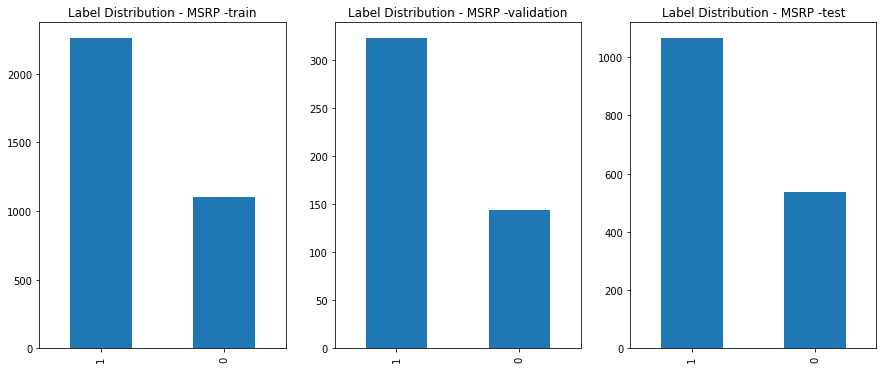

In [ ]:
d = {'train':df_msrp_train,'validation':df_msrp_val,'test':df_msrp_test}

plt.figure(figsize=(15,6))

for i,(k,v) in enumerate(d.items()):
  plt.subplot(1,3,i+1)
  v.label.value_counts().plot.bar();
  plt.title('Label Distribution - MSRP -' + k)

#### Augmentation


More data we have, better performance we can achieve. However, it is very too luxury to annotate large amount of training data. Therefore, proper data augmentation is useful to boost up your model performance. 

In natural language processing (NLP) field, it is hard to augmenting text due to high complexity of language. Not every word we can replace it by others such as a, an, the.   
Also, not every word has synonym. Even changing a word, the context will be totally difference. 

We choose to use `nlpaug` library becuase it's lightweight, quick and easy-to-use.

Various known textual augmentation techniques:
- Thesaurus
- Word Embeddings
- Contextualized Word Embeddings
- Back Translation
- Text Generation

Based on our dataset we choose 3 different operations:
- Generate a summary of the sentence.
- Insert words base on contextual embeddings.
- Translation from English to German and back to English. (very slow)

In [ ]:
AUG_FILE_NAME = current_dir+'data/df_msrp_train_aug.pkl'

def textual_augment(df_train,aug):
  df_train_aug = df_train.copy()

  q1 = df_train_aug.q1.tolist()
  q2 = df_train_aug.q2.tolist()

  df_train_aug.q1 = aug.augment(q1)
  df_train_aug.q2 = aug.augment(q2)

  return df_train_aug

def get_aug_df(df_train):
  global AUG_FILE_NAME

  aug_sum = nas.AbstSummAug(model_path='t5-base')
  aug_insert = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")
  aug_translate = naw.BackTranslationAug(from_model_name='facebook/wmt19-en-de', to_model_name='facebook/wmt19-de-en')

  # takes about an 1-2 hours
  df_ = df_train.copy()  
  df_ = df_.append(textual_augment(df_train.head(1000),aug_sum))
  df_ = df_.append(textual_augment(df_train.tail(1000),aug_insert))
  df_ = df_.append(textual_augment(df_train.head(2000).tail(1000),aug_translate))
  df_.to_pickle(AUG_FILE_NAME)

# if not exists create augmented df
if not os.path.exists(AUG_FILE_NAME):
  get_aug_df(df_msrp_train)

# augmented dataframe
df_msrp_train_aug = pd.read_pickle(AUG_FILE_NAME)

# augmented dataset
dataset_msrp_train_aug = PairDataset(df_msrp_train_aug.q1.values, df_msrp_train_aug.q2.values, df_msrp_train_aug.label.values)

df_msrp_train_aug.shape

(6361, 3)

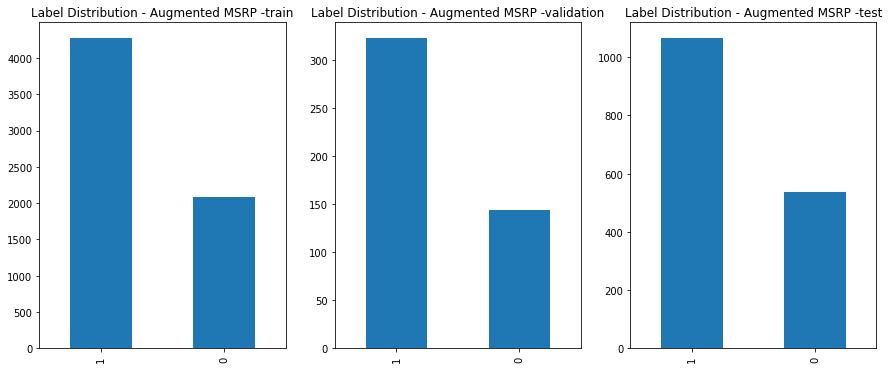

In [ ]:
d = {'train':df_msrp_train_aug,'validation':df_msrp_val,'test':df_msrp_test}

plt.figure(figsize=(15,6))

for i,(k,v) in enumerate(d.items()):
  plt.subplot(1,3,i+1)
  v.label.value_counts().plot.bar();
  plt.title('Label Distribution - Augmented MSRP -' + k)

### Fake News

##### Create a dataframe

In [ ]:
fake_news = current_dir + 'data/fake_news.csv'

df_fakenews = pd.read_csv(fake_news, index_col=0)
df_fakenews['label_binary'] = df_fakenews["label"].map({"REAL": 0, "FAKE": 1}).values.astype('float')

fakenews_column = 'title'
df_fakenews_train, df_fakenews_valid, df_fakenews_test = np.split(df_fakenews[[fakenews_column,'label_binary']].sample(frac=1), [int(.6*len(df_fakenews)), int(.8*len(df_fakenews))])

df_fakenews_train.shape,df_fakenews_valid.shape,df_fakenews_test.shape

((3801, 2), (1267, 2), (1267, 2))

##### Create Dataset

In [ ]:
dataset_fakenews_train = Dataset(df_fakenews_train.iloc[:,0].values, df_fakenews_train.iloc[:,1].values)
dataset_fakenews_val   = Dataset(df_fakenews_valid.iloc[:,0].values, df_fakenews_valid.iloc[:,1].values)
dataset_fakenews_test  = Dataset(df_fakenews_test.iloc[:,0].values, df_fakenews_test.iloc[:,1].values)

##### Distribution - Traget Labels  


''

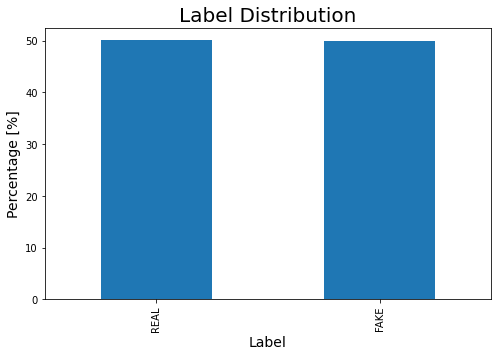

In [ ]:
plt.figure(figsize=(8,5))

(round(df_fakenews["label"].value_counts() / df_fakenews.shape[0] * 100, 2)).plot(kind="bar")
plt.title("Label Distribution", fontsize=20)
plt.xlabel("Label", fontsize=14)
plt.ylabel("Percentage [%]", fontsize=14)
;

Good. Each label has the same number of relative representation in the dataset, which means there is no need to "correct" the dataset.
<br><br>

<br><br><br><br>

## Models - Setup DL models

#### Model - BERT

In [ ]:
class model_BERT(nn.Module):
    def __init__(self,n_components=10,n_classes=1,model_name="bert-base-uncased",max_len=20,batch_size=64):
        super(model_BERT, self).__init__()

        self.batch_size = batch_size
        self.max_len = max_len

        self.tokenizer_bert = BertTokenizer.from_pretrained(model_name)
        self.model_bert = BertModel.from_pretrained(model_name)
        
        self.classifier = nn.Sequential(
            nn.Linear(768, 64, bias=True),
            nn.ReLU(),
            nn.Linear(64, n_classes, bias=True),
            nn.Sigmoid()
        )


    def tokenizing(self,sentences):
      return self.tokenizer_bert.batch_encode_plus(sentences,return_tensors='pt',add_special_tokens=False,padding="max_length",max_length=self.max_len, pad_to_max_length=True,truncation=True)['input_ids']

    def tokenizing_pair(self,sentences1,sentences2):
      return self.tokenizer_bert(sentences1,sentences2,return_tensors='pt',add_special_tokens=False,padding="max_length",max_length=self.max_len, pad_to_max_length=True,truncation=True)['input_ids']

    def forward(self, tokens_bert):

        # features
        features_bert = self.model_bert(tokens_bert).last_hidden_state[:, 0, :]

        # classification
        outputs = self.classifier(features_bert)
        return outputs 

#### Model - tBERT

In [ ]:
class model_tBERT(nn.Module):
    def __init__(self,n_components=10,n_classes=1,model_name="bert-base-uncased",max_len=50,batch_size=64,sentences=[''],isPair=0):
        super(model_tBERT, self).__init__()

        self.batch_size = batch_size
        self.max_len = max_len

        self.tokenizer_bert = BertTokenizer.from_pretrained(model_name)
        self.model_bert = BertModel.from_pretrained(model_name)
        
        self.model_lda = LDA(n_components=n_components,batch_size=batch_size,n_jobs=-1)
        self.sentences = [self.preprocessing(sentence) for sentence in sentences]
        
        self.sentences = self.tokenizing(self.sentences) # self.tokenizer_bert.batch_encode_plus(self.sentences,return_tensors='pt',padding=True,max_length=max_len, pad_to_max_length=True)['input_ids'][:,1:-1]
        self.model_lda.fit(self.sentences)

        self.classifier = nn.Sequential(
            nn.Linear(768 + n_components + isPair*n_components, 256, bias=True),
            nn.ReLU(),
            nn.Linear(256, 64, bias=True),
            nn.ReLU(),
            nn.Linear(64, 16, bias=True),
            nn.ReLU(),
            nn.Linear(16, 4, bias=True),
            nn.ReLU(),
            nn.Linear(4, n_classes, bias=True),
            nn.Sigmoid()
        )

    def preprocessing(self,sentence):
      sentence = str(sentence).lower()                                            # lower latters
      words = word_tokenize(sentence)                                             # split into words
      words = [word for word in words if word.isalpha()]                          # remove punctuations
      words = [word for word in words if word not in stopwords.words('english')]  # remove stopwords
      words = [word for (word, pos) in nltk.pos_tag(words) if pos[:2] == 'NN']    # keep nouns
      sentence = ' '.join(words)                                                  # combine words to a sentence
      return sentence

    def tokenizing(self,sentences):
      return self.tokenizer_bert.batch_encode_plus(sentences,return_tensors='pt',add_special_tokens=False,padding="max_length",max_length=self.max_len, pad_to_max_length=True,truncation=True)['input_ids']

    def tokenizing_pair(self,sentences1,sentences2):
      return self.tokenizer_bert(sentences1,sentences2,return_tensors='pt',add_special_tokens=True,padding="max_length",max_length=self.max_len, pad_to_max_length=True,truncation=True)['input_ids']

    def freeze_BERT(self,):
      for param in self.model_bert.parameters():
        param.requires_grad = False

    def forward(self, tokens_bert,features_lda):

        # features
        features_bert = self.model_bert(tokens_bert).last_hidden_state[:, 0, :]

        # concatenate
        features = torch.cat([features_lda, features_bert],dim=1)
        self.aa = features
        self.bb = features_bert
        
        # classification
        outputs = self.classifier(features)
        return outputs 

#### Setup Trainer

In [ ]:
class myTrainer():
  def __init__(self,
               model,
               train_dataset, val_dataset, test_dataset,
               epochs = 5, with_LDA = True, model_name = 'basemodel',current_dir = current_dir
               ):
    
    self.model = model
    self.epochs = epochs
    self.with_LDA = with_LDA
    self.model_name = str(model_name)
    self.current_dir = current_dir
    
    self.criterion = nn.BCELoss()
    self.optimizer = optim.Adam(self.model.parameters())
    self.train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    self.val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
    self.test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

    self.loss_train = []
    self.loss_val = []


  def train(self):
    min_valid_loss = np.inf
    
    # run on all epochs
    print(self.model_name + ': Training \t',end='')
    for e in range(self.epochs):
      # print()

      # train
      for data in self.train_dataloader:
        print('.',end='')

        if len(data)==3:
          self.train_loss_pair(data)
        else:
          self.train_loss(data)

      # eval      
      self.model.eval()     # Optional when not using Model Specific layer
      for data in self.val_dataloader:
        if len(data)==3:
          self.val_loss_pair(data)
        else:
          self.val_loss(data)
      
      # print progress
      # print(f'Epoch {e+1} \t\t Training Loss: {self.loss_train[-1] / len(self.train_dataloader)} \t\t Validation Loss: {self.loss_val[-1] / len(self.val_dataloader)}')

      # save the optimal model    
      if min_valid_loss > self.loss_val[-1]:
          # print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{self.loss_val[-1]:.6f})')
          min_valid_loss = self.loss_val[-1]
          self.save_model()

    # load best model
    self.load_model()      
    

  def train_loss(self,data):
    inputs, labels = data

    # Clear the gradients
    self.optimizer.zero_grad()

    # tokenizer
    tokens_bert = self.model.tokenizing(inputs)  #.tokenizer_bert.batch_encode_plus(inputs,return_tensors='pt',padding=True)['input_ids']
    tokens_bert = tokens_bert.cuda()

    # LDA
    if self.with_LDA:
      tokens_lda = self.model.tokenizing(inputs)
      features_lda = self.model.model_lda.transform(tokens_lda)
      features_lda = torch.tensor(features_lda).type(torch.FloatTensor)
      features_lda = features_lda.cuda()

      self.a = tokens_bert
      self.b = tokens_lda
      self.c = features_lda

      target = self.model(tokens_bert,features_lda)
    else:
      target = self.model(tokens_bert)
      
    # Find the Loss
    labels = labels.type(torch.FloatTensor).unsqueeze(1).cuda()
    loss = self.criterion(target,labels)

    # Calculate gradients 
    loss.backward()

    # Update Weights
    self.optimizer.step()

    # Calculate Loss
    train_loss = loss.item() * len(data)
    self.loss_train.append(train_loss)


  def train_loss_pair(self,data):
    inputs1, inputs2, labels = data

    # Clear the gradients
    self.optimizer.zero_grad()

    # tokenizer
    tokens_bert = self.model.tokenizing_pair(inputs1,inputs2)
    tokens_bert = tokens_bert.cuda()

    # LDA
    if self.with_LDA:
      # inputs1
      tokens_lda1 = self.model.tokenizing(inputs1)
      features_lda1 = self.model.model_lda.transform(tokens_lda1)
      features_lda1 = torch.tensor(features_lda1).type(torch.FloatTensor)
      
      # inputs2
      tokens_lda2 = self.model.tokenizing(inputs2)
      features_lda2 = self.model.model_lda.transform(tokens_lda2)
      features_lda2 = torch.tensor(features_lda2).type(torch.FloatTensor)
      
      features_lda = torch.cat([features_lda1, features_lda2],dim=1)
      features_lda = features_lda.cuda()
      target = self.model(tokens_bert,features_lda)
    else:
      target = self.model(tokens_bert)
      
    # Find the Loss
    labels = labels.type(torch.FloatTensor).unsqueeze(1).cuda()
    loss = self.criterion(target,labels)

    # Calculate gradients 
    loss.backward()

    # Update Weights
    self.optimizer.step()

    # Calculate Loss
    train_loss = loss.item() * len(data)
    self.loss_train.append(train_loss)


  def val_loss(self,data):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data

    labels = labels.type(torch.FloatTensor).unsqueeze(1).cuda()

    # tokenizer
    tokens_bert = self.model.tokenizing(inputs) #self.model.tokenizer_bert.batch_encode_plus(inputs,return_tensors='pt',padding=True)['input_ids']
    tokens_bert = tokens_bert.cuda()

    # LDA
    if self.with_LDA:
      tokens_lda = self.model.tokenizing(inputs)
      features_lda = self.model.model_lda.transform(tokens_lda)
      features_lda = torch.tensor(features_lda).type(torch.FloatTensor)
      features_lda = features_lda.cuda()      
      target = self.model(tokens_bert,features_lda)
    else:
      target = self.model(tokens_bert)
    
    # Find the Loss
    loss = self.criterion(target,labels)

    # Calculate Loss
    valid_loss = loss.item() * len(data)
    self.loss_val.append(valid_loss)


  def val_loss_pair(self,data):
    # get the inputs; data is a list of [inputs, labels]
    inputs1, inputs2, labels = data

    labels = labels.type(torch.FloatTensor).unsqueeze(1).cuda()

    # tokenizer
    tokens_bert = self.model.tokenizing_pair(inputs1,inputs2) 
    tokens_bert = tokens_bert.cuda()

    # LDA
    if self.with_LDA:
      # inputs1
      tokens_lda1 = self.model.tokenizing(inputs1)
      features_lda1 = self.model.model_lda.transform(tokens_lda1)
      features_lda1 = torch.tensor(features_lda1).type(torch.FloatTensor)
      
      # inputs2
      tokens_lda2 = self.model.tokenizing(inputs2)
      features_lda2 = self.model.model_lda.transform(tokens_lda2)
      features_lda2 = torch.tensor(features_lda2).type(torch.FloatTensor)
      
      features_lda = torch.cat([features_lda1, features_lda2],dim=1)
      features_lda = features_lda.cuda()
      target = self.model(tokens_bert,features_lda)
    else:
      target = self.model(tokens_bert)
    
    # Find the Loss
    loss = self.criterion(target,labels)

    # Calculate Loss
    valid_loss = loss.item() * len(data)
    self.loss_val.append(valid_loss)


  def predict(self):

    # results
    real_labels = []
    predictions = []

    self.model.eval()  
    with torch.no_grad():
      for data in self.test_dataloader:

        inputs, labels = data

        # tokenizer
        tokens_bert = self.model.tokenizing(inputs)
        tokens_bert = tokens_bert.cuda()
        
        # LDA
        if self.with_LDA:
          tokens_lda = self.model.tokenizing(inputs)
          features_lda = self.model.model_lda.transform(tokens_lda)
          features_lda = torch.tensor(features_lda).type(torch.FloatTensor)
          features_lda = features_lda.cuda()
          target = self.model(tokens_bert,features_lda)  
        else:
          target = self.model(tokens_bert)

    target = target.round()
    predictions.extend(target.cpu().detach()[:,0].tolist())
    real_labels.extend(labels.tolist())
    return real_labels,predictions


  def predict_pair(self):

    # results
    real_labels = []
    predictions = []

    self.model.eval() 
    with torch.no_grad():
      for data in self.test_dataloader:

        inputs1, inputs2, labels = data

        # tokenizer
        tokens_bert = self.model.tokenizing_pair(inputs1,inputs2)
        tokens_bert = tokens_bert.cuda()
        
        # LDA
        if self.with_LDA:
          tokens_lda1 = self.model.tokenizing(inputs1)
          features_lda1 = self.model.model_lda.transform(tokens_lda1)
          features_lda1 = torch.tensor(features_lda1).type(torch.FloatTensor)
          
          tokens_lda2 = self.model.tokenizing(inputs2)
          features_lda2 = self.model.model_lda.transform(tokens_lda2)
          features_lda2 = torch.tensor(features_lda2).type(torch.FloatTensor)
          
          features_lda = torch.cat([features_lda1, features_lda2],dim=1)
          features_lda = features_lda.cuda()
          target = self.model(tokens_bert,features_lda)  
        else:
          target = self.model(tokens_bert)

    target = target.round()
    predictions.extend(target.cpu().detach()[:,0].tolist())
    real_labels.extend(labels.tolist())
    return real_labels,predictions


  def save_model(self):
    # print('Saving the model... ',end='')
    with open(self.current_dir + 'results/'+ self.model_name +'.pkl', 'wb') as f:
      pickle.dump(self.model, f, pickle.HIGHEST_PROTOCOL)
    # print('done!')


  def load_model(self):
    # print('Loading the model... ',end='')
    with open(self.current_dir + 'results/'+ self.model_name +'.pkl', 'rb') as f:
      self.model = pickle.load(f)
    print('done!')


  def plot_losses(self):
    plt.figure(figsize=(20,6))

    plt.subplot(1,2,1)
    plt.plot(self.loss_train)
    plt.title('Train Loss')
    plt.xlabel('# batch')
    plt.ylabel('loss')

    plt.subplot(1,2,2)
    plt.plot(self.loss_val)
    plt.title('Validation Loss')
    plt.xlabel('# batch')
    plt.ylabel('loss');
    

## Train Models

In [ ]:
random.seed(123)

df = pd.DataFrame(columns=['TopicsNumber','tBERT_Accuracy','Loss_Train','Loss_Val'])

def add_result(topics, real_tbert, pred_tbert, loss_train, loss_val):
  accuracy_tbert = accuracy_score(y_true=real_tbert,y_pred=pred_tbert)
  df.loc[len(df)] = [str(topics),accuracy_tbert,loss_train,loss_val]

n_topics = [1,5]#,10,20,40,70,75,80,85,90]
all_sentences = df_msrp_train.q1.values.tolist()
all_sentences.extend(df_msrp_train.q2.values.tolist())
all_sentences = list(set(all_sentences))  

for n in n_topics:

  # model
  model_tbert = model_tBERT(sentences=all_sentences,isPair=1,n_components=n).cuda();
  model_tbert.freeze_BERT()

  # train
  trainer_tBERT = myTrainer(model_tbert,with_LDA=True,model_name='tbert_msrp_t'+str(n),train_dataset=dataset_msrp_train,val_dataset=dataset_msrp_val,test_dataset=dataset_msrp_test,epochs=2)
  trainer_tBERT.train()

  # predict
  real_tbert_msrp,pred_tbert_msrp = trainer_tBERT.predict_pair()

  # save model results
  add_result(n, real_tbert_msrp, pred_tbert_msrp,trainer_tBERT.loss_train,trainer_tBERT.loss_val)

  # free cuda
  model_tbert, trainer_tBERT = None, None
  gc.collect()
  empty_cache()

tbert_msrp_t1: Training 	..........................................................................................................done!
tbert_msrp_t5: Training 	..........................................................................................................done!


In [ ]:
df

,TopicsNumber,tBERT_Accuracy,Loss_Train,Loss_Val
0,1,0.333333,"[2.141146659851074, 2.1103595495224, 2.0799583...","[1.8533917665481567, 1.6275147199630737, 1.950..."
1,5,0.666667,"[2.1165043115615845, 2.1022889614105225, 2.085...","[1.6815360188484192, 1.965897560119629, 1.8345..."


In [ ]:
random.seed(123)

df_aug = pd.DataFrame(columns=['TopicsNumber','tBERT_Accuracy','Loss_Train','Loss_Val'])

def add_result(topics, real_tbert, pred_tbert, loss_train, loss_val):
  accuracy_tbert = accuracy_score(y_true=real_tbert,y_pred=pred_tbert)
  df_aug.loc[len(df)] = [str(topics),accuracy_tbert,loss_train,loss_val]

n_topics = [1,5,10,20,40,70,75,80,85,90]
all_sentences = df_msrp_train_aug.q1.values.tolist()
all_sentences.extend(df_msrp_train_aug.q2.values.tolist())
all_sentences = list(set(all_sentences))  

for n in n_topics:

  # model
  model_tbert = model_tBERT(sentences=all_sentences,isPair=1,n_components=n).cuda();
  model_tbert.freeze_BERT()

  # train
  trainer_tBERT = myTrainer(model_tbert,with_LDA=True,model_name='tbert_msrp_aug_t'+str(n),train_dataset=dataset_msrp_train_aug,val_dataset=dataset_msrp_val,test_dataset=dataset_msrp_test,epochs=2)
  trainer_tBERT.train()

  # predict
  real_tbert_msrp,pred_tbert_msrp = trainer_tBERT.predict_pair()

  # save model results
  add_result(n, real_tbert_msrp, pred_tbert_msrp,trainer_tBERT.loss_train,trainer_tBERT.loss_val)

  # free cuda
  model_tbert, trainer_tBERT = None, None
  gc.collect()
  empty_cache()

tbert_msrp_aug_t1: Training 	........................................................................................................................................................................................................done!


KeyboardInterrupt: ignored

## Evaluation

In [ ]:
df

,TopicsNumber,tBERT_Accuracy,Loss_Train,Loss_Val
0,1,0.666667,"[2.0924566984176636, 2.0804030299186707, 2.068...","[1.8155086040496826, 1.8367527723312378, 1.803..."
1,5,0.666667,"[2.177311420440674, 2.2173823714256287, 2.2177...","[1.7955526113510132, 1.8144970536231995, 1.942..."
2,10,0.666667,"[2.2215263843536377, 2.1406527757644653, 2.191...","[1.7380467653274536, 1.6336652040481567, 1.723..."
3,20,0.666667,"[2.047664523124695, 2.0264182090759277, 2.0469...","[1.5524212718009949, 1.9862555265426636, 1.809..."
4,40,0.666667,"[2.117625117301941, 2.137873649597168, 2.12076...","[1.6195578575134277, 1.8172300457954407, 1.866..."
5,70,0.666667,"[2.016288936138153, 2.0550114512443542, 1.8803...","[2.0821831226348877, 1.7927210927009583, 1.821..."
6,75,0.333333,"[2.4148170948028564, 2.246533155441284, 2.5021...","[2.265075445175171, 2.2480334043502808, 2.4695..."
7,80,0.333333,"[2.2442482709884644, 2.275786578655243, 2.2193...","[2.1826733350753784, 2.2095420956611633, 2.164..."
8,85,0.666667,"[2.1223658323287964, 2.143503427505493, 2.1133...","[1.7246893644332886, 1.8142887353897095, 1.591..."
9,90,0.000000,"[2.1631250381469727, 2.2389991879463196, 2.228...","[1.8560258746147156, 1.697511076927185, 1.8648..."


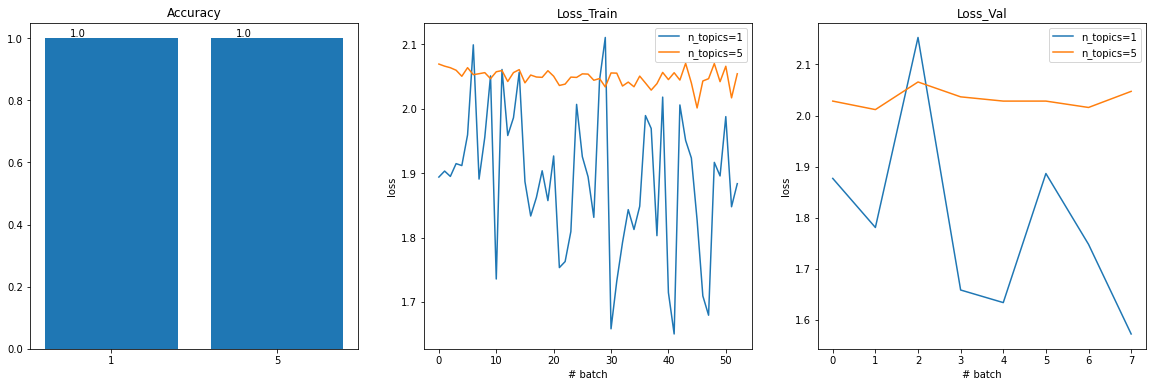

In [ ]:
plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
plt.bar(df.TopicsNumber,df.tBERT_Accuracy)
for index,data in enumerate(df.tBERT_Accuracy):
  plt.text(x=index-0.25, y=data+0.007, s="{:.3}".format(data) )
plt.title('Accuracy')

for j,c in enumerate(['Loss_Train','Loss_Val']):
  plt.subplot(1,3,j+2)
  for i in range(len(df)):
    y = df[c][i]
    x = list(range(len(y)))
    l = 'n_topics=' + str(df.TopicsNumber[i])  
    plt.plot(x,y,label=l)
  
  plt.title(c)
  plt.xlabel('# batch')
  plt.ylabel('loss')
  plt.legend()

plt.show()

##### Train BERT

Traning...

Epoch 1 		 Training Loss: 0.02492979566256205 		 Validation Loss: 0.07013005018234253
Validation Loss Decreased(inf--->1.402601)
Saving the model... done!

Epoch 2 		 Training Loss: 0.021475102504094443 		 Validation Loss: 0.06245769858360291
Validation Loss Decreased(1.402601--->1.249154)
Saving the model... done!

Epoch 3 		 Training Loss: 0.018155777454376222 		 Validation Loss: 0.06316390633583069

Epoch 4 		 Training Loss: 0.018017097314198812 		 Validation Loss: 0.05610558986663818
Validation Loss Decreased(1.249154--->1.122112)
Saving the model... done!

Epoch 5 		 Training Loss: 0.010602582494417827 		 Validation Loss: 0.0708433210849762
Loading the model... done!


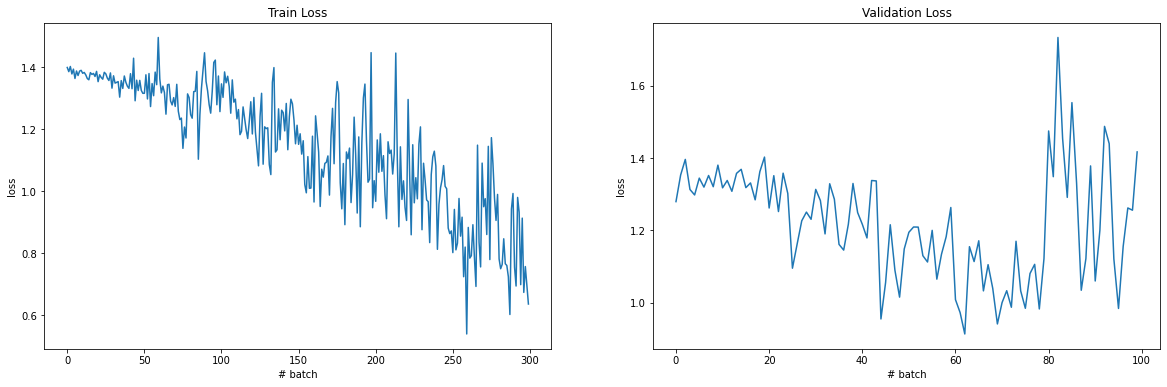

In [ ]:
# model
model_bert = model_BERT().cuda();

# train
trainer_BERT = myTrainer(model_bert,with_LDA=False,model_name='bert_fakenews',train_dataset=dataset_fakenews_train,val_dataset=dataset_fakenews_val,test_dataset=dataset_fakenews_test)
trainer_BERT.train()

# predict
real_bert_fakenews,pred_bert_fakenews = trainer_BERT.predict()

# plot
trainer_BERT.plot_losses()

# free cuda
model_bert, trainer_BERT = None, None
gc.collect()
empty_cache()

Traning...

Epoch 1 		 Training Loss: 0.0454322641546076 		 Validation Loss: 0.21307269483804703
Validation Loss Decreased(inf--->1.704582)
Saving the model... done!

Epoch 2 		 Training Loss: 0.03800161535089666 		 Validation Loss: 0.236243337392807

Epoch 3 		 Training Loss: 0.05883473266254772 		 Validation Loss: 0.25190721452236176

Epoch 4 		 Training Loss: 0.01925589550625194 		 Validation Loss: 0.20888091623783112
Validation Loss Decreased(1.704582--->1.671047)
Saving the model... done!

Epoch 5 		 Training Loss: 0.02257368402047591 		 Validation Loss: 0.24033931642770767
Loading the model... done!


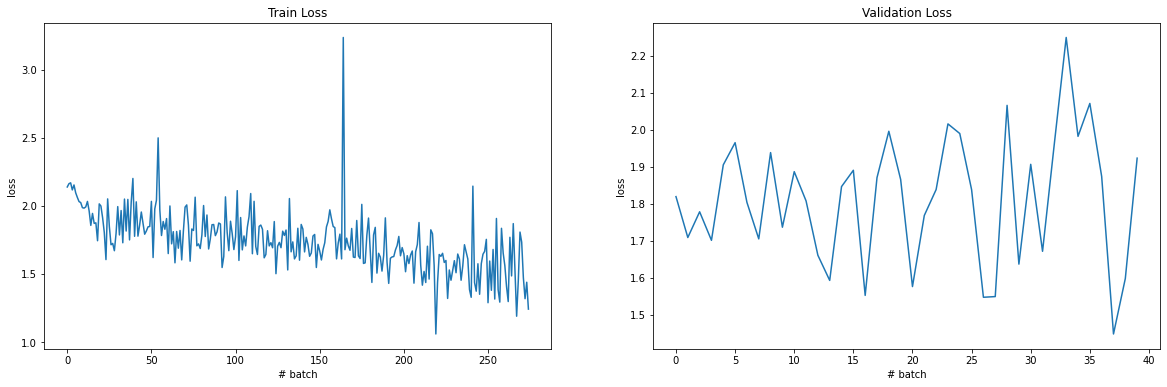

In [ ]:
# model
model_bert = model_BERT().cuda();

# train
trainer_BERT = myTrainer(model_bert,with_LDA=False,model_name='bert_msrp',train_dataset=dataset_msrp_train,val_dataset=dataset_msrp_val,test_dataset=dataset_msrp_test)
trainer_BERT.train()

# predict
real_bert_msrp,pred_bert_msrp = trainer_BERT.predict_pair()

# plot
trainer_BERT.plot_losses()

# free cuda
model_bert, trainer_BERT = None, None
gc.collect()
empty_cache()

Train tBERT

Traning...

Epoch 1 		 Training Loss: 0.02017153302828471 		 Validation Loss: 0.06541470289230347
Validation Loss Decreased(inf--->1.308294)
Saving the model... done!

Epoch 2 		 Training Loss: 0.022039278348286947 		 Validation Loss: 0.06216956973075867
Validation Loss Decreased(1.308294--->1.243391)
Saving the model... done!

Epoch 3 		 Training Loss: 0.016266321142514546 		 Validation Loss: 0.05297099351882935
Validation Loss Decreased(1.243391--->1.059420)
Saving the model... done!

Epoch 4 		 Training Loss: 0.01237084964911143 		 Validation Loss: 0.05298537015914917

Epoch 5 		 Training Loss: 0.014521790544191997 		 Validation Loss: 0.04035727977752686
Validation Loss Decreased(1.059420--->0.807146)
Saving the model... done!
Loading the model... done!


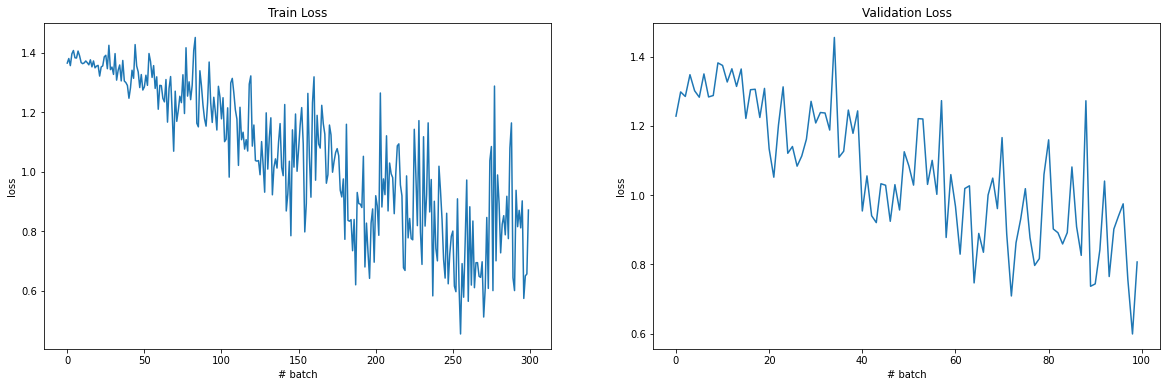

In [ ]:
# model
model_tbert = model_tBERT(sentences= set(df_fakenews_train.title.values.tolist()) ).cuda();

# train
trainer_tBERT = myTrainer(model_tbert,with_LDA=True,model_name='tbert_fakenews',train_dataset=dataset_fakenews_train,val_dataset=dataset_fakenews_val,test_dataset=dataset_fakenews_test)
trainer_tBERT.train()

# predict
real_tbert_fakenews,pred_tbert_fakenews = trainer_tBERT.predict()

# plot
trainer_tBERT.plot_losses()

# free cuda
model_tbert, trainer_tBERT = None, None
gc.collect()
empty_cache()

Traning...

Epoch 1 		 Training Loss: 0.03792053461074829 		 Validation Loss: 0.19340705126523972
Validation Loss Decreased(inf--->1.547256)
Saving the model... done!

Epoch 2 		 Training Loss: 0.01736314676024697 		 Validation Loss: 0.19432054460048676

Epoch 3 		 Training Loss: 0.023585795272480357 		 Validation Loss: 0.24287912249565125

Epoch 4 		 Training Loss: 0.0237594951282848 		 Validation Loss: 0.1949966847896576

Epoch 5 		 Training Loss: 0.02281706604090604 		 Validation Loss: 0.20813407748937607
Loading the model... done!


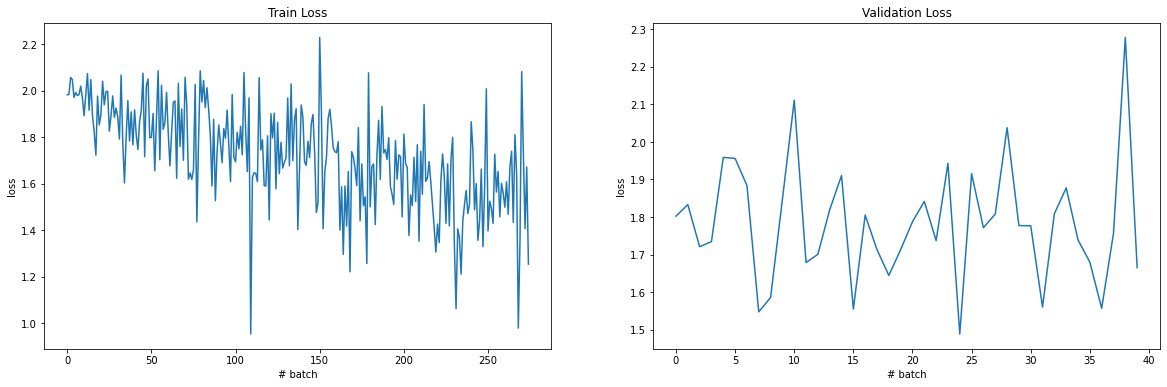

In [ ]:
# model
all_sentences = df_msrp_train.q1.values.tolist()
all_sentences.extend(df_msrp_train.q2.values.tolist())
all_sentences = list(set(all_sentences))
model_tbert = model_tBERT(sentences=all_sentences,isPair=1).cuda();

# train
trainer_tBERT = myTrainer(model_tbert,with_LDA=True,model_name='tbert_msrp',train_dataset=dataset_msrp_train,val_dataset=dataset_msrp_val,test_dataset=dataset_msrp_test)
trainer_tBERT.train()

# predict
real_tbert_msrp,pred_tbert_msrp = trainer_tBERT.predict_pair()

# plot
trainer_tBERT.plot_losses()

# free cuda
model_tbert, trainer_tBERT = None, None
gc.collect()
empty_cache()

## Evaluation

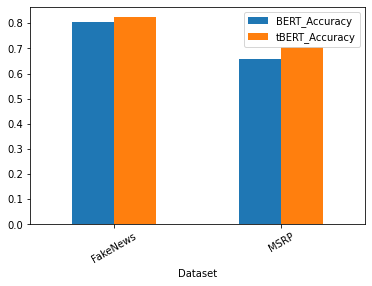

In [ ]:
df = pd.DataFrame(columns=['Dataset','BERT_Accuracy','tBERT_Accuracy'])

def add_result(dataset, real_bert, pred_bert, real_tbert, pred_tbert):
  accuracy_bert  = accuracy_score(y_true=real_bert, y_pred=pred_bert)
  accuracy_tbert = accuracy_score(y_true=real_tbert,y_pred=pred_tbert)
  df.loc[len(df)] = [str(dataset),accuracy_bert,accuracy_tbert]

add_result('FakeNews',real_bert_fakenews,pred_bert_fakenews,real_tbert_fakenews,pred_tbert_fakenews)
add_result('MSRP',real_bert_msrp,pred_bert_msrp,real_tbert_msrp,pred_tbert_msrp)

df.plot.bar(x='Dataset');
plt.xticks(rotation=30);

Thanks For Reading... :))

- results - more then the baseline
- focus on MSRP - YES
- HP with package (70-90 LDA)- more models 
- Augmentation - would it improve?
- Sentiment analysis - ? 
- DistilBERT - ?